<a href="https://colab.research.google.com/github/gupta1000/image-analogies/blob/master/img_analogies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS445 Final Project: Image Analogies
#### Michael Kokkines (mgk3) & Kush Gupta (kg3)


Something about image analogies

**Setup**

In [0]:
import cv2
import numpy as np
from scipy import signal

%matplotlib inline
from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

In [0]:
!pip install annoy
from annoy import AnnoyIndex

In [0]:
A_fname = "apple.jpg"
Ap_fname = "apple_p.jpg"
B_fname = "tomato.jpg"

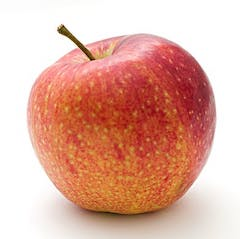

In [4]:
A = cv2.imread(A_fname, cv2.IMREAD_UNCHANGED)
cv2_imshow(A)

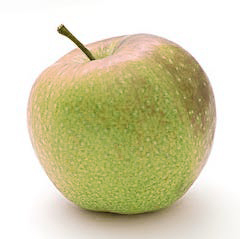

In [5]:
A_p = cv2.imread(Ap_fname, cv2.IMREAD_UNCHANGED)
cv2_imshow(A_p)

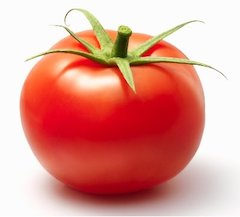

In [6]:
B = cv2.imread(B_fname, cv2.IMREAD_UNCHANGED)
cv2_imshow(B)

In [0]:
# levels
L = 3 

# We typically use 2 ≤ K ≤ 25 for color non-photorealistic filters,
# K = 1 for line art filters, and 0.5 ≤ K ≤ 5 for texture synthesis.

# K = .5   # luminance
# K = -1   # contrast
# K = -1   # recolorize
# K = -1   # color adjust
# K = -0.5 # texture transfer

K = -1

In [34]:
b_p_f = create_image_analogy(A, A_p, B, L)

matched A[0 0] to B[0 0] using app @l(0) - [9.93164062e+01 1.56250000e-02 0.00000000e+00]
matched A[ 6 37] to B[4 17] using app @l(0) - [96.18530273  0.234375    4.125     ]
matched A[28 18] to B[8 34] using app @l(0) - [75.59204102  0.09375    32.09375   ]
matched A[13 51] to B[12 51] using app @l(0) - [90.7043457  1.4375     4.609375 ]
matched A[19  0] to B[16 7] using app @l(1) - [9.91455078e+01 1.56250000e-02 0.00000000e+00]
matched A[38 16] to B[80 15] using app @l(1) - [91.33300781 -1.390625    4.96875   ]
matched A[20 81] to B[24 24] using app @l(1) - [88.80615234  1.5        12.84375   ]
matched A[28 72] to B[88 32] using app @l(1) - [73.18115234 -9.421875   39.203125  ]
matched A[27 48] to B[32 41] using app @l(1) - [75.78125  -5.703125 40.703125]
matched A[49 45] to B[96 49] using app @l(1) - [ 69.90356445 -11.4375      44.484375  ]
matched A[43 49] to B[40 58] using app @l(1) - [ 66.13769531 -14.828125    46.953125  ]
matched A[109  68] to B[104 66] using app @l(1) - [96.319

In [0]:
b_p = reconstruct_luminance(b_p_f, b, L-1)

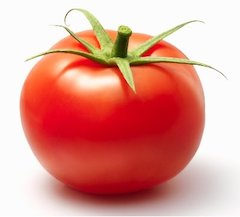

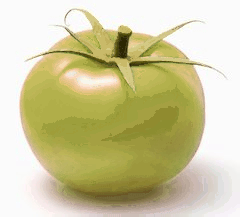

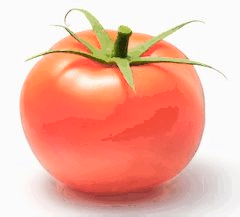

In [36]:
cv2_imshow(B)
cv2_imshow(cv2.cvtColor(b_p_f[2].astype('float32'), cv2.COLOR_LAB2BGR) * 255)
cv2_imshow(b_p)

**Gaussian Computation**

In [0]:
def gaussian_kernel(sigma, kernel_half_size):
    window_size = kernel_half_size*2+1
    gaussian_kernel_1d = signal.gaussian(window_size, std=sigma).reshape(window_size, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)
    return gaussian_kernel_2d

In [0]:
def gaussian_pyr(im, levels):
  images = [ im ]
  kernel = gaussian_kernel(4, 16)

  for i in range(levels - 1):
    prev_img = cv2.resize(
      signal.convolve2d(
          images[-1], 
          kernel, 
          boundary="symm", 
          mode="same"
        ),
        None, 
        fx=.5, 
        fy=.5
    )
    images.append(prev_img)
  
  return images


def gaussian_pyr_rgb(im, levels):
  red_images = gaussian_pyr(im[:, :, 0], levels)
  green_images = gaussian_pyr(im[:, :, 1], levels)
  blue_images = gaussian_pyr(im[:, :, 2], levels)

  images = []
  for i in range(len(red_images)):
    img = np.zeros((red_images[i].shape[0], red_images[i].shape[1], 3))
    img[:, :, 0] = red_images[i]
    img[:, :, 1] = green_images[i]
    img[:, :, 2] = blue_images[i]
    images.append(img)
  
  return images[::-1]

In [0]:
def build_gaussians(A, A_p, B, L):
  a = gaussian_pyr_rgb(A, L)
  a_p = gaussian_pyr_rgb(A_p, L)
  b = gaussian_pyr_rgb(B, L)
  return a, a_p, b

**Feature Computation**

In [0]:
num_features = 3

In [0]:
def compute_features(im):
  feature_vec = np.zeros((im.shape[0], im.shape[1], num_features))

  # extract luminance
  lab_im = cv2.cvtColor((im/255).astype('float32'), cv2.COLOR_BGR2LAB)
  feature_vec[:,:,0:3] = lab_im

  # # Add the RGB channels
  # feature_vec[:,:,1:4] = im

  return feature_vec

In [0]:
def compute_featuresets(a, a_p, b, L):
  a_feat = []
  a_p_feat = []
  b_feat = []
  b_p_feat = []
  s = []
  for l in range(L):
    a_feat.append(compute_features(a[l]))
    a_p_feat.append(compute_features(a_p[l]))
    b_feat.append(compute_features(b[l]))
    b_p_feat.append(np.zeros(b_feat[-1].shape))
    s.append(np.zeros((b_feat[-1].shape[0], b_feat[-1].shape[1], 2)))
  return a_feat, a_p_feat, b_feat, b_p_feat, s

**Pixel Matching**

*Approximate Matching*

In [0]:
def rob_neighborhood(im, p, fine_bound=2):
  p_x = int(p[0])
  p_y = int(p[1])

  # move window center if given point is too close to edge
  if (p_x - fine_bound < 0):
    p_x = fine_bound
  if (p_x + fine_bound >= im.shape[1]):
    p_x = im.shape[1] - fine_bound - 1
  if (p_y - fine_bound < 0):
    p_y = fine_bound
  if (p_y + fine_bound >= im.shape[0]):
    p_y = im.shape[0] - fine_bound -1

  return normalize_f(im[p_y-fine_bound:p_y+fine_bound+1, p_x-fine_bound:p_x+fine_bound+1]).flatten()


In [0]:
def plant_forest(im, L):
  forests = []
  pixel_maps = []

  for l in range(L):
    # We decided to use Manhattan distance
    ann = AnnoyIndex(3*5*5, "manhattan")
    
    # Initialize the pixel map
    num_indices = im[l].shape[0] * im[l].shape[1] 
    index_to_pixel = np.zeros((num_indices, 2))

    lab = cv2.cvtColor((im[l] / 255.0).astype("float32"), cv2.COLOR_BGR2LAB)
      
    i = 0
    for r in range(im[l].shape[0]):
      for c in range(im[l].shape[1]):
        ann.add_item(i, rob_neighborhood(lab, (c, r)))
        index_to_pixel[i, :] = np.array([c, r])
        i += 1
    
    # Create a forest of ten trees
    ann.build(10)
    forests.append(ann)
    pixel_maps.append(index_to_pixel)
  
  return forests, pixel_maps

In [0]:
def best_approx_match(forest, pixel_map, b, q):
  index = forest.get_nns_by_vector(rob_neighborhood(b,q), 1, search_k=forest.get_n_items())[0]
  return pixel_map[index].astype('int32')

*Feature Distance*

In [0]:
def normalize_f(f):
  # print(f)
  norm = np.zeros(f.shape)
  gk = gaussian_kernel(f.shape[0]/10, int(f.shape[0]/2))
  for i in range(num_features):
    norm[:,:,i] = f[:,:,i] * gk
  return norm

In [0]:
# TODO: make this not the most horrible thing in existance
def concat_feat(fpyr, p, l, fine_bound=2, coarse_bound=1):
  p_x = int(p[0])
  p_y = int(p[1])
  lpyr = fpyr[l]
  f_coarse = np.zeros((2 * coarse_bound + 1)**2*num_features)

  # move window center if given point is too close to edge
  if (p_x - fine_bound < 0):
    p_x = fine_bound
  if (p_x + fine_bound >= fpyr[l].shape[1]):
    p_x = fpyr[l].shape[1] - fine_bound - 1
  if (p_y - fine_bound < 0):
    p_y = fine_bound
  if (p_y + fine_bound >= fpyr[l].shape[0]):
    p_y = fpyr[l].shape[0] - fine_bound -1

  f = normalize_f(lpyr[p_y-fine_bound:p_y+fine_bound+1, p_x-fine_bound:p_x+fine_bound+1]).flatten()

  if (l > 0):
    p_x = int(p_x/2)
    p_y = int(p_y/2)

    # move window center if given point is too close to edge
    if (p_x - coarse_bound < 0):
      p_x += coarse_bound
    if (p_x + coarse_bound >= fpyr[l-1].shape[1]):
      p_x -= coarse_bound
    if (p_y - coarse_bound < 0):
      p_y += coarse_bound
    if (p_y + coarse_bound >= fpyr[l-1].shape[0]):
      p_y -= coarse_bound
      
    f_coarse = normalize_f(fpyr[l-1][p_y-coarse_bound:p_y+coarse_bound+1,p_x-coarse_bound:p_x+coarse_bound+1]).flatten()
  
  return np.concatenate((f, f_coarse), axis=0) 

In [0]:
def F_l(a_f, a_p_f, p, l):
  return np.concatenate((concat_feat(a_f, p, l), concat_feat(a_p_f, p, l)), axis=0)

In [0]:
def feature_dist(a_f, a_p_f, b_f, b_p_f, p, q, l, fine_bound=2, coarse_bound=1):
  return np.linalg.norm(F_l(a_f, a_p_f, p, l) - F_l(b_f, b_p_f, q, l), ord=2)

*Coherence Matching*

In [0]:
def best_coherence_match(a_f, a_p_f, b_f, b_p_f, s, q, l, N=2):
  min_dist = float('inf')
  match = [-1, -1]
  for r in range(q[1]-N,q[1]+1):
    for c in range(q[0]-N,q[0]+N):
      # do not consider pixels outside of image boundary (cannot go below q because scan-line order)
      if (r < 0 or c < 0 or c >= a_f[l].shape[1]): continue
      # break when current pixel is reached, to only consider previously synthesied pixels
      if (q == (c, r)): return np.array(match).astype('int32'), min_dist

      # get corresponding pixel based on previous match and relative position 
      fsr = (s[l][r,c] + q - [c,r])
      # skip match if it is outside bounds of source image
      if (fsr[0] < 0 or fsr[1] < 0 or fsr[0] >= a_f[l].shape[1] or fsr[1] >= a_f[l].shape[0]): continue

      # compute distance between potential match and current
      d = feature_dist(a_f, a_p_f, b_f, b_p_f, fsr, q, l)

      # argmin
      if (d < min_dist):
        min_dist = d
        match = fsr
      
  return np.array(match).astype('int32'), min_dist


*Matching Core*

In [0]:
def best_match(a_f, a_p_f, b_f, b_p_f, a_forest, pixel_maps, s, q, l, lab, N=2):
  p_app = best_approx_match(a_forest[l], pixel_maps[l], lab, q)

  # if near image boundary, skip coherence method
  if (q[0] < N or q[1] < N or q[0] + N >= b_p_f[l].shape[1] or q[1] + N >= b_p_f[l].shape[0]):
    return p_app, "app"

  p_coh, dist_coh = best_coherence_match(a_f, a_p_f, b_f, b_p_f, s, q, l, N)
  if (p_coh[0] == -1 and p_coh[1] == -1):
    return p_app, "app"

  dist_app = feature_dist(a_f, a_p_f, b_f, b_p_f, p_app, q, l)

  if (dist_coh <= (dist_app * (1 + 2**(l - L) * K))):
    return p_coh, "coh" 
  return p_app, "app"

In [0]:
def match_all(a_f, a_p_f, b_f, b_p_f, b, a_forest, pixel_maps, s, L):
  i = 0
  for l in range(L):
    lab = cv2.cvtColor((b[l] / 255.0).astype("float32"), cv2.COLOR_BGR2LAB)
    for q_y in range(b_f[l].shape[0]):
      for q_x in range(b_f[l].shape[1]):
        p, method = best_match(a_f, a_p_f, b_f, b_p_f, a_forest, pixel_maps, s, (q_x, q_y), l, lab)
        b_p_f[l][q_y,q_x] = a_p_f[l][p[1],p[0]]
        s[l][q_y,q_x] = p
        if (i%1024==0): print("matched A" + str(p) + " to B[" + str(q_x) + " " + str(q_y) + "] using " + method + " @l(" + str(l) + ") - " + str(a_p_f[l][p[1],p[0]])) 
        i+=1
  return b_p_f

**Image Analogies Core**

Automated Runs

In [0]:
# create image analogy for image B using references A : A_p
# using a gaussian pyramid of the specified number of levels 'L'
def create_image_analogy(A, A_p, B, L):

  # step 1: create gaussian pyramids for A, A_p, and B
  a, a_p, b = build_gaussians(A, A_p, B, L)
  # step 2: compute features for A, A_p, and B
  a_f, a_p_f, b_f, b_p_f, s = compute_featuresets(a, a_p, b, L)
  # step 3: init ann
  a_forest, pixel_maps = plant_forest(a, L)

  # step 4: solve for best matches
  b_p_f = match_all(a_f, a_p_f, b_f, b_p_f, b, a_forest, pixel_maps, s, L)

  return b_p_f

In [0]:
# this reconstruction will work on luminance filter analogies
def reconstruct_luminance(pyr, b, l):
  lab = cv2.cvtColor((b[l]/255.0).astype("float32"), cv2.COLOR_BGR2LAB)
  lab[:,:,0] = pyr[l][:,:,0]
  lab = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  return lab * 255

Unit Testing

In [0]:
a, a_p, b = build_gaussians(A, A_p, B, L)

In [0]:
cv2_imshow(b[0])
cv2_imshow(b[1])
cv2_imshow(b[2])

In [0]:
a_f, a_p_f, b_f, b_p_f, s = compute_featuresets(a, a_p, b, L)

In [0]:
a_forest, pixel_maps = plant_forest(a, L)

In [0]:
b_p_f = match_all(a_f, a_p_f, b_f, b_p_f, b, a_forest, pixel_maps, s, L)

In [0]:
b_p = reconstruct_luminance(b_p_f, b, L-1)

In [0]:
cv2_imshow(b[2])
cv2_imshow(cv2.cvtColor(a_p_f[2].astype('float32'), cv2.COLOR_LAB2BGR) * 255)
cv2_imshow(cv2.cvtColor(b_p_f[2].astype('float32'), cv2.COLOR_LAB2BGR) * 255)
cv2_imshow(b_p)